<a href="https://colab.research.google.com/github/adityaranjan08/Ecommerce-Product-Categorization/blob/main/E_com_product_categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Understanding the Data
Before performing any processing on the available data, exploratory data analysis is recommended. This process includes visualization of the data for better understanding, identifying the outliers, and skewed predictors

In [32]:
#Data Manipulation

import numpy as np

import pandas as pd

# Visualization

import matplotlib.pyplot as plt

import seaborn as sns

import keras

from keras.preprocessing.text import Tokenizer

from keras.models import Sequential

from keras.layers import Dense

from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten,Conv1D, MaxPooling1D

from keras.models import Model

from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

from keras import layers

#NLP for text pre-processing

import nltk

from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS

# for spliting data set and metrics

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

#Handling imbalance data

from imblearn.over_sampling import SMOTE

# Plot the Figures Inline

%matplotlib inline

In [33]:

# Let's import the data and understand the columns.

# Loading the dataset

product_data = pd.read_csv('/content/train_product_data.csv')

product_data.shape

(14999, 15)

In [34]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  14999 non-null  object 
 1   crawl_timestamp          14999 non-null  object 
 2   product_url              14999 non-null  object 
 3   product_name             14999 non-null  object 
 4   product_category_tree    14999 non-null  object 
 5   pid                      14999 non-null  object 
 6   retail_price             14942 non-null  float64
 7   discounted_price         14942 non-null  float64
 8   image                    14996 non-null  object 
 9   is_FK_Advantage_product  14999 non-null  bool   
 10  description              14998 non-null  object 
 11  product_rating           14999 non-null  object 
 12  overall_rating           14999 non-null  object 
 13  brand                    10289 non-null  object 
 14  product_specifications

The e-commerce data set has 15 attributes; out of these columns, we only extracted the following elements for further analysis: description and product_category_tree.

The remaining columns are not considered for building the text classification model. So, only the description column is considered useful.

#Exploratory Data Analysis
Before moving ahead, let's look at the distribution of each category.

In [35]:
import pandas as pd

# Assuming the dataframe is named product_data

# Split the product category tree column by ">>" and extract the first level category

product_data['product_category'] = product_data['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())

# Getting the frequency count of each category
category_counts = product_data['product_category'].value_counts()


# Display the top 20 categories
categories = category_counts.head(20)
print(categories)

product_category
Clothing                      5316
Jewellery                     3218
Footwear                      1083
Automotive                     937
Mobiles & Accessories          768
Home Decor & Festive Needs     714
Kitchen & Dining               610
Computers                      531
Watches                        526
Tools & Hardware               379
Toys & School Supplies         271
Pens & Stationery              264
Baby Care                      224
Bags, Wallets & Belts          158
Name: count, dtype: int64


<Axes: title={'center': 'Product Category Breakdown'}, xlabel='product_category'>

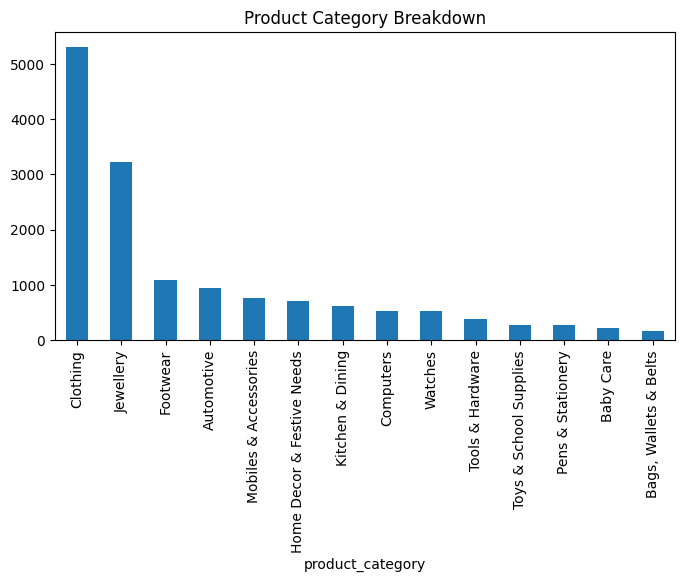

In [36]:
fig, ax = plt.subplots(figsize=[8,4], nrows=1, ncols=1)
categories.plot(ax=ax, kind='bar', title='Product Category Breakdown')

#Data Preprocessing
Here we perform certain data preprocessing steps, including data cleaning,preparation,transformation and dimensionality reduction.

First we investigate the usual data set level cleaning and then later jump into text preprocessing.

Let's see if there are any missing values in the description column.

In [37]:
# Number of missing values in each column

missing_values = pd.DataFrame (product_data.isnull().sum()).rename(columns = {0:'Missing Values'})

# Create a percentage of missing values

missing_values['Percentage'] = missing_values['Missing Values'] / len(product_data) * 100

# Sorting the values in descending order to see highest count on the top

missing_values.sort_values('Percentage',ascending = False)

,Missing Values,Percentage
brand,4710,31.402093
retail_price,57,0.380025
discounted_price,57,0.380025
product_specifications,6,0.040003
image,3,0.020001
description,1,0.006667
uniq_id,0,0.000000
crawl_timestamp,0,0.000000
product_url,0,0.000000
product_name,0,0.000000


In [38]:
# Removing missing values in description

product_data = product_data[pd.notnull(product_data['description'])]

<ipython-input-39-fe9e486aa855>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['no_of_words'] = product_data.description.apply(lambda a : len(a.split()))
<ipython-input-39-fe9e486aa855>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['bins'] = pd.cut(product_data.no_of_words, bins = [0,100,300,500,800,np.inf], labels = ['0-100','100-200','200-500','500-800','>800'])


Text(0.5, 1.0, 'Word distribution per bin')

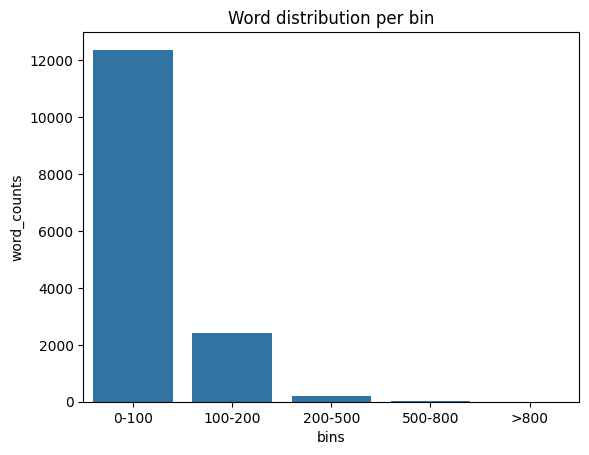

In [39]:
product_data['no_of_words'] = product_data.description.apply(lambda a : len(a.split()))

bins = [0,50,75, np.inf]

product_data['bins'] = pd.cut(product_data.no_of_words, bins = [0,100,300,500,800,np.inf], labels = ['0-100','100-200','200-500','500-800','>800'])

words_distribution = product_data.groupby('bins').size().reset_index().rename(columns = {0:'word_counts'})

sns.barplot(x='bins',y='word_counts',data = words_distribution).set_title("Word distribution per bin")

#Text Preprocessing
We observed the value thar text preprocessing lends to many text-related tasks. Let's jump into implementation .

The following is data before text preprocessing.

In [40]:
product_data['description'][8]

"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, White, Black,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentle Machine Wash in Lukewarm Water, Do Not Bleach Additional Details Style Code ALTHT_3P_17 In the Box 3 shorts"

In [41]:
# Remove Punctuation

product_data['description'] = product_data['description'].str.replace(r'[^\w\d\s]',' ')

# Replace whitespace between terms with a single space

product_data['description'] = product_data['description'].str.replace(r'\s+',' ')

# Remove leading and trailing whitespace

product_data['description'] = product_data['description'].str.replace(r'^\s+|\s+$','')

# converting to lowercase

product_data['description'] = product_data['description'].str.lower()

# Replace numbers like price values with 'numbr'

product_data['description' ] = product_data['description'].str.replace(r'\d+(\.\d+)?','numbr')

product_data['description'][8]

"key features of alisha solid women's cycling shorts cotton lycra black, white, black,specifications of alisha solid women's cycling shorts shorts details number of contents in sales package pack of 3 fabric cotton lycra type cycling shorts general details pattern solid ideal for women's fabric care gentle machine wash in lukewarm water, do not bleach additional details style code altht_3p_17 in the box 3 shorts"

The stop words are imported from the NLTK library and are removed from the description.There are two kinds of stop words.

1.   General stop words like an and in appear everywhere irrespective of the domain. It doesn't matter where the text is coming from.
2.   There are few domain-specific stop words. For example , buy,com,and cash can appear only in certain domains,such as e-commerce and retail.We need to remove them as well.



In [42]:
# Removing Stopwords

import nltk
nltk.download('stopwords')

stop = stopwords.words('english')

pattern = r'\b(?:{})\b'.format('|'.join(stop))

product_data['description'] = product_data['description'].str.replace(pattern, '')


product_data['description'] = product_data['description'].str.replace(r'\s+', '')

#Replace single characters

product_data['description'] = product_data['description'].apply(lambda a: " ".join(a for a in a.split() if len(a)>1))

product_data['description'][8]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"key features of alisha solid women's cycling shorts cotton lycra black, white, black,specifications of alisha solid women's cycling shorts shorts details number of contents in sales package pack of fabric cotton lycra type cycling shorts general details pattern solid ideal for women's fabric care gentle machine wash in lukewarm water, do not bleach additional details style code altht_3p_17 in the box shorts"

Let's plot word cloud on descriptions to get to know the words that are appearing the greatest number of times.

In [43]:
wordcloud = WordCloud (background_color="white", width = 800, height = 400).generate(' '.join(product_data['description']))


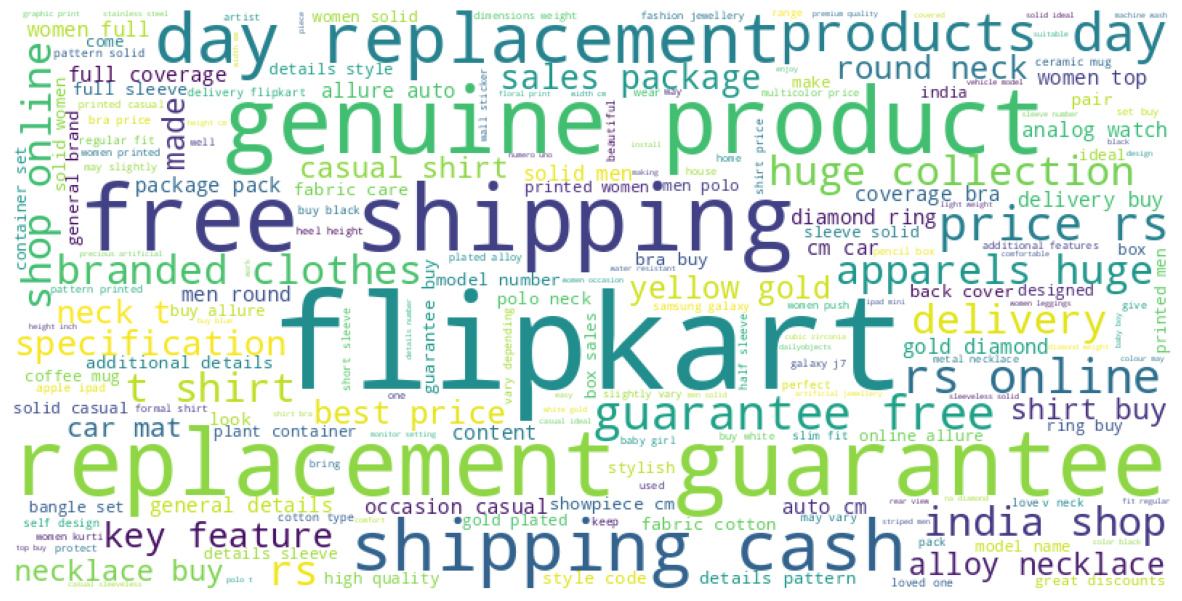

In [44]:
plt.figure(figsize = (15,8))

plt.imshow(wordcloud)

plt.axis("off")

plt.show()

There are a lot of domain-related words occuring in the corpus,which add no value to the task.For example ,the word rs is an indian currency present in most documents but not useful. Let's remove these domain-related stop words and plot again.

In [45]:
# Removing domain-related stop words from the description.

specific_stop_words = ["numbr", "rs", "flipkart", "buy", "com", "free", "day", "cash", "replacement", "guarantee", "genuine", "key", "feature", "delivery", "products", "shipping", "online", "india", "shop",]

product_data['description'] = product_data['description'].apply(lambda a: " ".join(a for a in a.split() if a not in specific_stop_words))


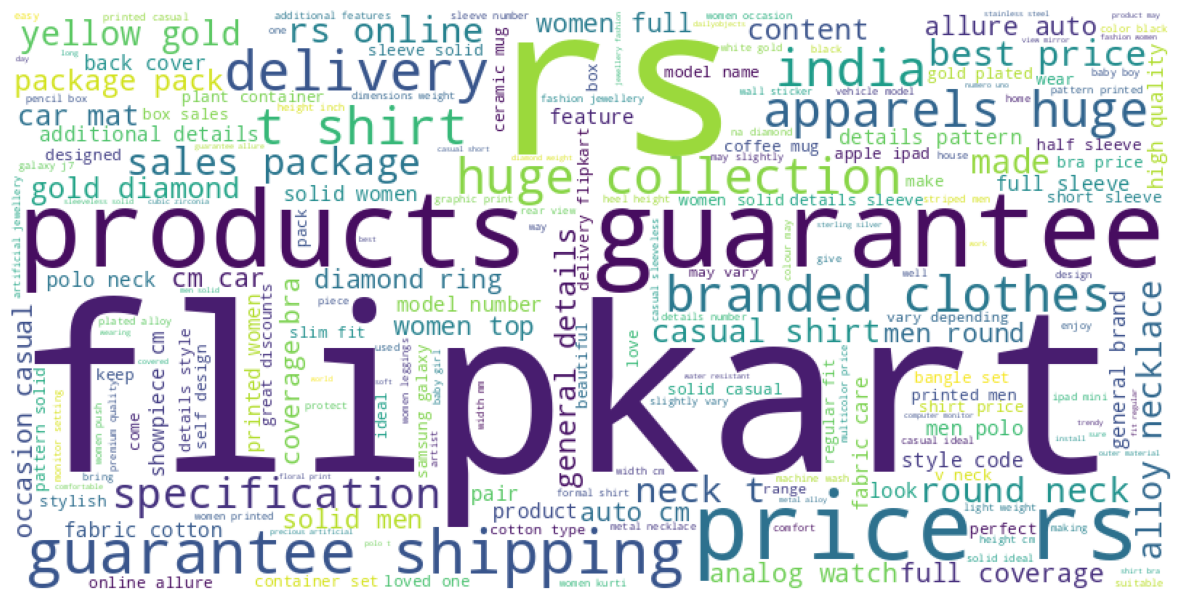

In [46]:
wordcloud =  WordCloud (background_color="white", width = 800, height = 400).generate(' '.join(product_data['description']))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)

plt.axis("off")

plt.show()

Note that there are words related to the product categories.Once the data is cleaned, we can proceed with the feature engineering.

#Feature Engineering

To build the text classification model, we need to first convert the text data into features.

We use deep learning algorithms to build the classifier, and feature extraction should be carries out accordingly. We use Keras tokenizer function to generate features.We are setting max_length to 200, which means we are only considering 200 features for the classifier.This number also decides the accuracy,and the ideal number can be obtained from the hyperparameter tuning.

In [47]:
MAX_LENGTH = 200

prod_token = Tokenizer()

prod_token.fit_on_texts(product_data['description'])

clean_description = prod_token.texts_to_sequences(product_data['description'])

clean_description = pad_sequences(clean_description, maxlen=MAX_LENGTH)

Like features,we need to also convert the target variable.We use label encoding to do so. This function is LabelEncoder from sklearn

#Train-Test Split

The data is split into two parts: one for training the model and one for evaluating the model.

The train_test_split library from sklearn.model_selection is imported to split the data frame

In [48]:
# Label encoder for target variable

from sklearn.preprocessing import LabelEncoder

num_class = len(np.unique (product_data.product_category_tree.values))

y = product_data['product_category_tree'].values

encoder = LabelEncoder()

encoder.fit(y)

encoded_y = encoder.transform(y)

In [49]:
# train test split

from sklearn.model_selection import train_test_split

independent_features_build, independent_features_valid, dependent_feature_build, dependent_feature_valid = train_test_split(clean_description, encoded_y, test_size=0.2, random_state=1) #train 80, test 20

print(independent_features_build.shape)

print(independent_features_valid.shape)

print(dependent_feature_build.shape)

print(dependent_feature_valid.shape)

(11998, 200)
(3000, 200)
(11998,)
(3000,)


#Model Building
This following list of classifiers is used for creating various classification models,which can be further used for prediction.
  1. Simple baseline artificial neural networks (ANNs)
  2. Recurrent neural networks (RNN-LSTM)
  3. Convolutional neural networks
  

#ANN
Let's start with the basic neural network using imbalanced data.

The following is the architecture for the neural network. The input neurons are the max_length defined earlier. Then there is an embedding or hidden layer with a linear activation function by default, but we can also use ReLU. In the end, there us a softmax layer with 14 neurons since there are 14 categories. We are using rmsprop optimizer with categorical cross-entropy as a loss function.

In [50]:
model_inp = Input(shape=(MAX_LENGTH,))

vocab_size = len(prod_token.word_index) + 1 # Adding 1 for the unknown token( index 0 )

object_layer = Embedding(vocab_size, 100, input_length=MAX_LENGTH)(model_inp)

a = Flatten()(object_layer)

a = Dense(30)(a)

# Default activation function is linear, we can make use of relu.

mmodel_pred = Dense(num_class, activation='softmax')(a)

output = Model(inputs=[model_inp], outputs=mmodel_pred)

output.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

output.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 100)          2036200   
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_4 (Dense)             (None, 30)                600030    
                                                                 
 dense_5 (Dense)             (None, 14)                434       
                                                                 
Total params: 2636664 (10.06 MB)
Trainable params: 2636664 (10.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
filepath = "output_ANN.hdf5"

X = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# fit the model

out = output.fit([independent_features_build],batch_size=64, y = to_categorical (dependent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=50, callbacks=[X])


# predict

output_pred = output.predict([independent_features_valid])

output_pred = np.argmax(output_pred, axis=1)

accuracy_score = (dependent_feature_valid, output_pred)


Epoch 1/50
140/141 [============================>.] - ETA: 0s - loss: 0.9049 - accuracy: 0.7441
Epoch 1: val_accuracy improved from -inf to 0.89267, saving model to output_ANN.hdf5
141/141 [==============================] - 4s 24ms/step - loss: 0.9025 - accuracy: 0.7447 - val_loss: 0.3974 - val_accuracy: 0.8927
Epoch 2/50
  7/141 [>.............................] - ETA: 2s - loss: 0.3066 - accuracy: 0.9241

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


141/141 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.9537
Epoch 2: val_accuracy improved from 0.89267 to 0.94767, saving model to output_ANN.hdf5
141/141 [==============================] - 3s 23ms/step - loss: 0.1943 - accuracy: 0.9537 - val_loss: 0.1986 - val_accuracy: 0.9477
Epoch 3/50
140/141 [============================>.] - ETA: 0s - loss: 0.0635 - accuracy: 0.9860
Epoch 3: val_accuracy improved from 0.94767 to 0.95233, saving model to output_ANN.hdf5
141/141 [==============================] - 5s 35ms/step - loss: 0.0635 - accuracy: 0.9861 - val_loss: 0.1627 - val_accuracy: 0.9523
Epoch 4/50
139/141 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9917
Epoch 4: val_accuracy improved from 0.95233 to 0.95900, saving model to output_ANN.hdf5
141/141 [==============================] - 3s 22ms/step - loss: 0.0299 - accuracy: 0.9917 - val_loss: 0.1517 - val_accuracy: 0.9590
Epoch 5/50
141/141 [==============================] - ETA: 0s -

#Long Short-Term Memory: Recurrent Neural Networks

we tried out normal neural network which don't capture the sequence of the data. let's try a long short-term memory network where the sequence is also captured while training the model. This is best suited for text since text data is sequential.

The following is the architecture for the neural network. The input neurons are the max_length we defined earlier.An LSTM layer follows an embedding layer. In the end, there us a softmax layer with 14 neurons. We are using a rmsprop optimizer with categorical cros  entropy as a loss function.

In [52]:
model_inp = Input(shape=(MAX_LENGTH,))

# defining embedding layer

object_layer =  Embedding(vocab_size, 100, input_length=MAX_LENGTH)(model_inp)

# defining LSTM layer

a = LSTM(60)(object_layer)

# defining dense layer

a = Dense(30)(a)

# Default activation function is linear, we can make use of relu.

# final

mmodel_pred = Dense(num_class, activation='softmax')(a)

output = Model(inputs=[model_inp], outputs=mmodel_pred)

output.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

output.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 200, 100)          2036200   
                                                                 
 lstm_1 (LSTM)               (None, 60)                38640     
                                                                 
 dense_6 (Dense)             (None, 30)                1830      
                                                                 
 dense_7 (Dense)             (None, 14)                434       
                                                                 
Total params: 2077104 (7.92 MB)
Trainable params: 2077104 (7.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score

filepath = "output_LSTM.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# fit the model

out = output.fit([independent_features_build],batch_size=64, y = to_categorical (dependent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=50, callbacks=[X])

# output.load_weights('output_LSTM.hdf5')

# predicting on validation data

output_pred = output.predict([independent_features_valid])

output_pred = np.argmax(output_pred, axis=1)

# score
accuracy_score = (dependent_feature_valid, output_pred)

Epoch 1/50
141/141 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998
Epoch 1: val_accuracy did not improve from 0.96833
141/141 [==============================] - 29s 205ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.2715 - val_accuracy: 0.9633
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9998
Epoch 2: val_accuracy did not improve from 0.96833
141/141 [==============================] - 29s 204ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.2626 - val_accuracy: 0.9643
Epoch 3/50
141/141 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990
Epoch 3: val_accuracy did not improve from 0.96833
141/141 [==============================] - 29s 206ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.2685 - val_accuracy: 0.9590
Epoch 4/50
141/141 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9993
Epoch 4: val_accuracy did not improve from 0.96833
141/141 [=

Text(0, 0.5, 'Accuracy')

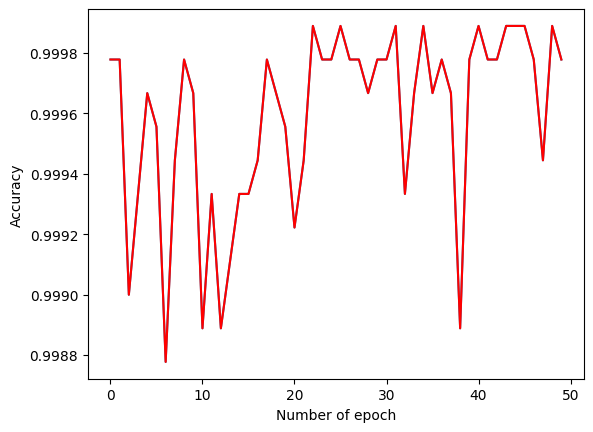

In [57]:
dfaccuracy = pd.DataFrame({'Number of epoch': out.epoch, 'Model hist': out.history['accuracy'], 'Model Perd': out.history['accuracy']})

# Line for train accuracy
g = sns.lineplot(x="Number of epoch", y="Model hist", data=dfaccuracy)

# Line for test accuracy
g = sns.lineplot(x="Number of epoch", y="Model Perd", data=dfaccuracy, color='red')

# set y-axis label
g.set_ylabel('Accuracy')

#Convolutional Neural Networks

These types of networks are mainly used for image processing . But recent trends show that CNN is performing well on text data if the right parameters are used. Let's see how well it performs in this case.

The following is the architecture for the neural network. The input neurons are the max_length defined earlier.Everything remains the same. Just as there are convolution and max pooling layers between an embedding layer and LSTM layer,there is a softmax layer with 14 neurons. We are using a rmsprop optimizer with categorical cross-entropy as a loss function.

In [60]:
model_inp = Input(shape=(MAX_LENGTH, ))

# definfe the layer

object_layer = Embedding(vocab_size, 100, input_length=MAX_LENGTH)(model_inp)

# conv layer

a = Conv1D(60,10) (object_layer) # default activation function is linear, we can make use of relu

# add pooling layer

a = MaxPooling1D(pool_size=2) (a)

# add LSTM

a = LSTM(60)(a)

# add dense layer

a = Dense(30)(a)  # Default activation function is linear, we can make use of relu.


# final layer

mmodel_pred = Dense(num_class, activation='softmax')(a)

output = Model(inputs=[model_inp], outputs=mmodel_pred)

output.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

output.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 200, 100)          2036200   
                                                                 
 conv1d (Conv1D)             (None, 191, 60)           60060     
                                                                 
 max_pooling1d (MaxPooling1  (None, 95, 60)            0         
 D)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 60)                29040     
                                                                 
 dense_8 (Dense)             (None, 30)                1830      
                                                           

In [62]:
filepath = "output_CNN.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

out = output.fit([independent_features_build],batch_size=64, y = to_categorical (dependent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=50, callbacks=[X])

# output.load_weights('output_CNN.hdf5')

predicted = output.predict([independent_features_valid])

predicted = np.argmax(predicted, axis=1)

accuracy_score = (dependent_feature_valid, predicted)


Epoch 1/50
141/141 [==============================] - ETA: 0s - loss: 5.6236e-04 - accuracy: 0.9999
Epoch 1: val_accuracy did not improve from 0.96833
141/141 [==============================] - 32s 229ms/step - loss: 5.6236e-04 - accuracy: 0.9999 - val_loss: 0.3202 - val_accuracy: 0.9623
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 5.0764e-04 - accuracy: 0.9999
Epoch 2: val_accuracy did not improve from 0.96833
141/141 [==============================] - 29s 208ms/step - loss: 5.0764e-04 - accuracy: 0.9999 - val_loss: 0.3227 - val_accuracy: 0.9630
Epoch 3/50
141/141 [==============================] - ETA: 0s - loss: 4.6809e-04 - accuracy: 0.9999
Epoch 3: val_accuracy did not improve from 0.96833
141/141 [==============================] - 29s 205ms/step - loss: 4.6809e-04 - accuracy: 0.9999 - val_loss: 0.3159 - val_accuracy: 0.9613
Epoch 4/50
141/141 [==============================] - ETA: 0s - loss: 4.7725e-04 - accuracy: 0.9999
Epoch 4: val_accuracy did not imp

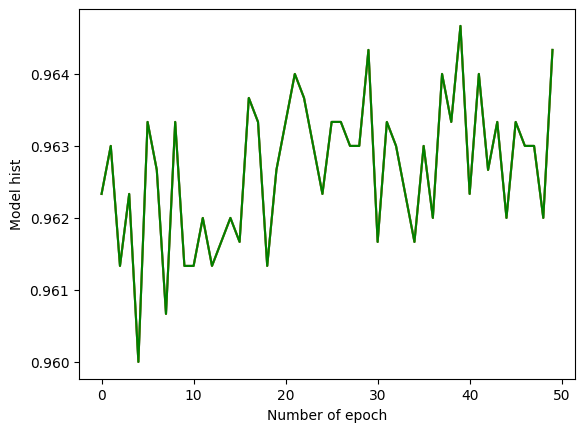

In [64]:
dfaccuracy = pd.DataFrame({'Number of epoch': out.epoch, 'Model hist': out.history['val_accuracy'], 'Model Perd': out.history['val_accuracy']})

# Line for train accuracy

g = sns.lineplot(x="Number of epoch", y="Model hist", data=dfaccuracy)

# Line for test accuracy
g = sns.lineplot(x="Number of epoch", y="Model Perd", data=dfaccuracy)

# Line for test accuracy
g = sns.lineplot(x="Number of epoch", y="Model Perd", data=dfaccuracy, color='green')